# Model developing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('../data/booli_apartments.csv')

# Drop address and city as it is individual for each apartment and all apartments are in same area
data = data.drop(['address', 'city'], axis=1)

# Convert 'date' to datetime and extract year and month
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data = data.drop('date', axis=1)

# Convert 'top_floor' to int64
data['top_floor'] = data['top_floor'].astype('int64')

# Drop multi-collinear features
data = data.drop(['price_change', 'price_per_m2', 'ask_price', 'total_floors'], axis=1)

data.head()

,rooms,area,floor,top_floor,elevator,balcony,sell_price,interest_rate,year,month
0,2.0,54.0,6.0,0,1,0,3000000,3.75,2024,5
1,2.0,55.5,2.0,0,1,0,3250000,3.75,2024,5
2,2.0,42.0,1.0,0,0,0,3095000,4.00,2024,1
3,1.5,39.0,4.0,0,1,0,2450000,4.00,2024,5
4,2.0,55.0,8.0,1,1,0,3866000,3.75,2024,5


In [3]:
data.dtypes

rooms            float64
area             float64
floor            float64
top_floor          int64
elevator           int64
balcony            int64
sell_price         int64
interest_rate    float64
year               int32
month              int32
dtype: object

In [4]:
Y = data['sell_price']
X = data.drop(['sell_price'], axis=1)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
# Assuming you have a validation set (X_val, Y_val)
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         booster='dart', 
                         n_estimators=1000, 
                         max_depth=5, 
                         learning_rate=0.02, 
                         tree_method='hist',
                         device='cuda')
model.fit(X_train, Y_train, 
          eval_set=[(X_train, Y_train), (X_test, Y_test)],
          verbose=100)

[0]	validation_0-rmse:831382.84201	validation_1-rmse:817089.77724
[100]	validation_0-rmse:448652.32855	validation_1-rmse:466236.61387
[200]	validation_0-rmse:400424.99589	validation_1-rmse:438390.63490
[300]	validation_0-rmse:378570.05703	validation_1-rmse:430466.31546
[400]	validation_0-rmse:364517.97350	validation_1-rmse:427472.66532
[500]	validation_0-rmse:352174.64805	validation_1-rmse:427306.83284
[600]	validation_0-rmse:340177.69660	validation_1-rmse:424921.97927
[700]	validation_0-rmse:330763.70821	validation_1-rmse:422907.82238
[800]	validation_0-rmse:320714.11143	validation_1-rmse:420770.53938
[900]	validation_0-rmse:312750.25518	validation_1-rmse:419958.86586
[999]	validation_0-rmse:306681.29737	validation_1-rmse:420584.39851


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
# Predict the test set
Y_pred = model.predict(X_test)

# Calculate the mean squared error to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 176891144302.9005


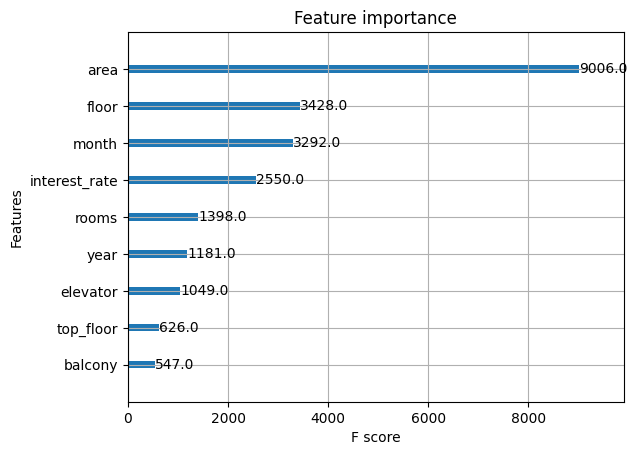

In [7]:
# Feature importance
feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
xgb.plot_importance(model)
plt.show()

In [8]:
# Calculate mean sell_price
print(f'Mean Sell Price: {data["sell_price"].mean()}')

rmse_test = 420584.39851
# Relative RMSE
relative_rmse = rmse_test / data['sell_price'].mean()
print(f'Relative RMSE: {relative_rmse*100:.2f}%')

Mean Sell Price: 3377537.164305949
Relative RMSE: 12.45%


In [9]:
# Create interaction variables
X_train['interest_rate_elevator'] = X_train['interest_rate'] * X_train['elevator']
X_test['interest_rate_elevator'] = X_test['interest_rate'] * X_test['elevator']
X_train['interest_rate_balcony'] = X_train['interest_rate'] * X_train['balcony']
X_test['interest_rate_balcony'] = X_test['interest_rate'] * X_test['balcony']
X_train['interest_rate_top_floor'] = X_train['interest_rate'] * X_train['top_floor']
X_test['interest_rate_top_floor'] = X_test['interest_rate'] * X_test['top_floor']

# Train the model with the new interaction variables
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         booster='dart', 
                         n_estimators=1000, 
                         max_depth=5, 
                         learning_rate=0.02, 
                         tree_method='hist',
                         device='cuda')
model.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_test, Y_test)],
            verbose=100)

[0]	validation_0-rmse:831354.73160	validation_1-rmse:817082.00248
[100]	validation_0-rmse:448128.16435	validation_1-rmse:468241.78990
[200]	validation_0-rmse:399888.64050	validation_1-rmse:443168.45984
[300]	validation_0-rmse:378916.37012	validation_1-rmse:436367.71547
[400]	validation_0-rmse:364993.40062	validation_1-rmse:434452.60271
[500]	validation_0-rmse:354418.48185	validation_1-rmse:435306.86797
[600]	validation_0-rmse:343491.81009	validation_1-rmse:434755.35094
[700]	validation_0-rmse:331947.63296	validation_1-rmse:435111.43870
[800]	validation_0-rmse:324150.70308	validation_1-rmse:434396.82769
[900]	validation_0-rmse:316730.32985	validation_1-rmse:435061.62345
[999]	validation_0-rmse:309615.06622	validation_1-rmse:435118.33594


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
# Predict the test set
Y_pred = model.predict(X_test)

# Calculate the mean squared error to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 189328142489.81198


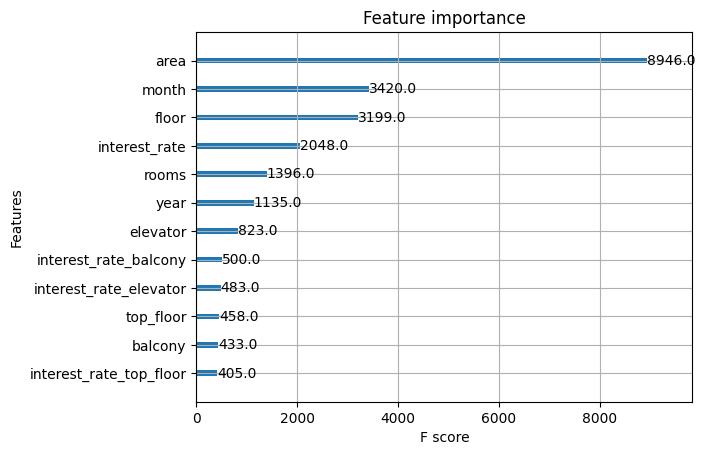

In [11]:
# Feature importance
feature_importance = model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
xgb.plot_importance(model)
plt.show()

In [12]:
# Calculate mean sell_price
print(f'Mean Sell Price: {data["sell_price"].mean()}')

rmse_test = 435118.33594
# Relative RMSE
relative_rmse = rmse_test / data['sell_price'].mean()
print(f'Relative RMSE: {relative_rmse*100:.2f}%')

Mean Sell Price: 3377537.164305949
Relative RMSE: 12.88%


In [20]:
# Print Descriptive Statistics
data_descriptive = pd.DataFrame(data.describe())

# Export data_descriptive to Excel in the ../data folder
data_descriptive.to_excel('../data/data_descriptive.xlsx')

# Print data_descriptive
print(data_descriptive)

             rooms         area        floor    top_floor     elevator  \
count  2471.000000  2471.000000  2471.000000  2471.000000  2471.000000   
mean      1.772562    50.490490     3.012546     0.164711     0.246054   
std       0.425731    13.021238     1.832744     0.370994     0.430798   
min       1.000000    20.000000    -3.000000     0.000000     0.000000   
25%       1.500000    39.000000     2.000000     0.000000     0.000000   
50%       2.000000    52.000000     3.000000     0.000000     0.000000   
75%       2.000000    60.500000     4.000000     0.000000     0.000000   
max       2.500000   108.000000    15.000000     1.000000     1.000000   

           balcony    sell_price  interest_rate         year        month  
count  2471.000000  2.471000e+03    2471.000000  2471.000000  2471.000000  
mean      0.100364  3.377537e+06       0.695366  2020.708215     6.171186  
std       0.300546  8.395866e+05       1.523733     1.801779     3.385405  
min       0.000000  1.425000e